In [1]:
#imports

import numpy as np
from keras.models import load_model
import keras

from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

print('Notebook run using keras:', keras.__version__)


2023-06-17 20:55:25.370377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Notebook run using keras: 2.10.0


In [2]:
#suppress warnings
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Load Model

In [3]:
# Load the Keras model
model = load_model('saved_myXception_model.h5')

2023-06-17 20:55:29.930395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 20:55:29.932474: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Make Deprocessing to Undo Preprocessing (Needed Later)

In [4]:
########################################
# deprocess function
#
# Inputs [I] & Outputs [O]:
# [I] processed_img: image that has been processed by model preprocessing 
#
# Description
#
#   MyXception does not preprocess image so just make sure it is unit8

def deprocess(processed_img): 
    return processed_img.astype("uint8") 


# Load Data To Examine

In [5]:
n=56
image_path = "/home/dm/ml_n_code/sandbox/cats_vs_dogs/data/train/Cat/" + str(n)+".jpg"


In [6]:
image_size = (180, 180)  

img_raw = image.load_img(image_path, target_size=image_size)
x = image.img_to_array(img_raw)
x = np.expand_dims(x, axis=0)
#MyXception does not preprocess image so skip preprocessing step

out = []
out.append(x)
data=np.vstack(out)

Text(0.5, 1.0, 'Original')

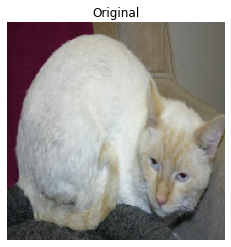

In [7]:
#check input image
plt.imshow(img_raw)
plt.axis("off")
plt.title("Original")


Text(0.5, 1.0, 'Inverse-Preprocessing Check')

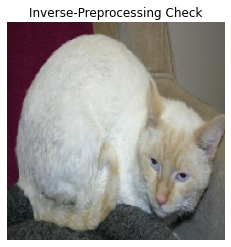

In [8]:
#spot-check deprocess function
plt.imshow(deprocess(data[0]))
plt.axis("off")
plt.title("Inverse-Preprocessing Check")


In [9]:
preds = model.predict(data)
for x in preds:
    score = float(x)
    print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")


2023-06-17 20:55:31.732684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/add_2/add' exist for missing node 'model/add_1/add'.
2023-06-17 20:55:31.778418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/add_2/add' exist for missing node 'model/add_1/add'.


1/1 [==============================] - 1s 578ms/step
This image is 89.24% cat and 10.76% dog.


# Find Explanations

In [10]:
import lime
from lime import lime_image

In [11]:
# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()

In [12]:
# Explain the prediction
explanation = explainer.explain_instance(
        data[0].astype('double'),
        model.predict,
        top_labels=2,  # Set the number of top labels to include in the explanation
        hide_color=0, 
        num_samples=1000,  # Set the number of samples to use in LIME
    )


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Explanation')

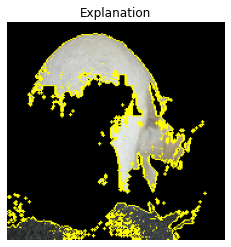

In [13]:
#see the explanation for the top class -- just show positive parts
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(deprocess(temp), mask))
plt.axis("off")
plt.title("Explanation")


Text(0.5, 1.0, 'Mask')

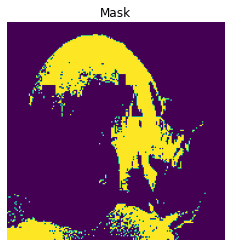

In [14]:
#show region label mask
plt.figure()
plt.imshow(mask)
plt.axis("off")
plt.title('Mask')

Text(0.5, 1.0, 'Explanation with Rest of Image')

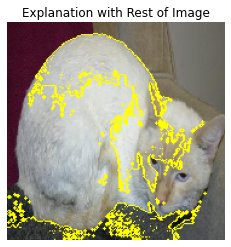

In [15]:
#see the explanation for the top class -- with the rest of the image present

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(deprocess(temp), mask))
plt.axis("off")
plt.title('Explanation with Rest of Image')

Text(0.5, 1.0, 'Explanation Pros (Green) and Cons (Red)')

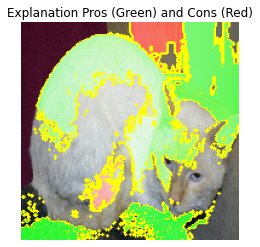

In [16]:
#see the 'pros and cons' (pros in green, cons in red)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(deprocess(temp), mask))
plt.axis("off")
plt.title('Explanation Pros (Green) and Cons (Red)')

Text(0.5, 1.0, 'Explanation Heatmap')

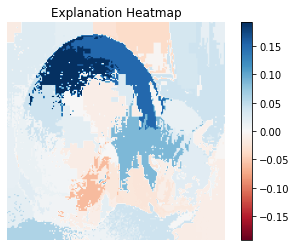

In [17]:
#explanation weights heatmap visualization


#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.axis("off")
plt.title('Explanation Heatmap')

In [18]:
explanation.top_labels[0] #for result, cat = 0, dog = 1

0